In [1]:
import matplotlib.pyplot as plt
import numpy as np
from MetaArray import MetaArray
from acq4.util.z_stack_splitter import split_z_stacks

record = MetaArray(file='/home/martin/src/acq4/junk_data/2024.10.17_000/video_000.ma')


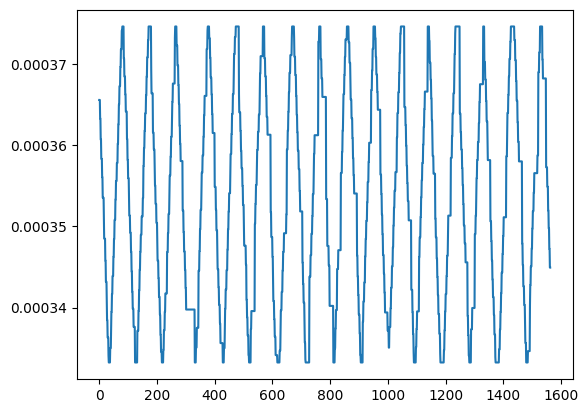

In [2]:
meta = record._info[0]
target_x = meta['translation'][-1, 0]
relevant = meta['translation'][:, 0] == target_x
relevant = relevant.nonzero()[0]
z_positions = meta['translation'][relevant, 2]

# plot the z values
plt.plot(z_positions)

In [3]:
stacks = split_z_stacks(z_positions, 1e-7)
stacks = stacks[1:-1]  # the first and last stacks are usually incomplete
print(len(stacks))

31


In [4]:
cell = record[relevant]
img_stacks = [np.array([cell[i] for i in st]) for st in stacks]
target = (514, 511)

# make the first stack the reference stack
reference = img_stacks.pop(0)
reference.shape

(20, 1024, 1024)

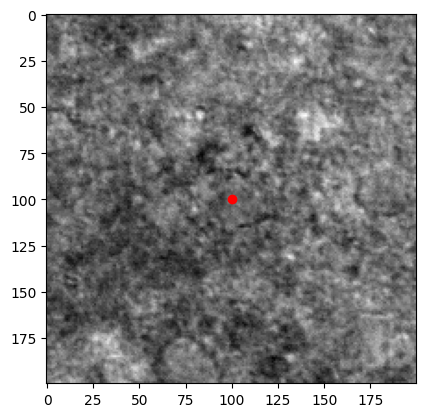

In [5]:
# display region to confirm selection

plt.imshow(reference[reference.shape[0] // 2, 414:614, 411:611], cmap='gray')
plt.scatter(100, 100, c='r')

In [6]:
# reverse every other stack
for i, stack in enumerate(img_stacks):
    if i % 2 == 0:
        img_stacks[i] = stack[::-1]

In [7]:
avg_z_step = (z_positions[stacks[0][-1]] - z_positions[stacks[0][0]]) / (len(stacks[0]) - 1)

In [8]:
from acq4.util.visual_tracker import ObjectStack, PyrLK3DTracker, CellPoseTracker

px = 3.24e-7
reference_stack = ObjectStack(
    reference,
    px_size=px,
    z_step=avg_z_step,
    obj_center=(len(reference) // 2, *target),
)
tracker = CellPoseTracker()
tracker.set_tracked_object(reference_stack)


/home/martin/.miniforge3/envs/acq4-torch/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [9]:
from acq4.util.visual_tracker import ImageStack

result = tracker.next_frame(reference_stack)
print(result['updated_object_stack'].obj_center)

z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'


(10, 514, 511)


In [10]:
results = [tracker.next_frame(ImageStack(st, px_size=px, z_step=avg_z_step)) for st in img_stacks[:10]]

z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'
z_axis not specified, assuming it is dim 0
if this is actually the channel_axis, use 'model.eval(channel_axis=0, ...)'
z_axis not specified, assuming it is dim 0
if th

(20, 1024, 1024) [ 10 514 511]
(20, 1024, 1024) [ 10 514 511]
(20, 1024, 1024) [ 10 514 511]
(20, 1024, 1024) [ 10 514 511]
(20, 1024, 1024) [ 10 514 511]
(20, 1024, 1024) [ 10 514 511]
(20, 1024, 1024) [ 10 514 511]
(20, 1024, 1024) [ 10 514 511]
(20, 1024, 1024) [ 10 514 511]
(20, 1024, 1024) [ 10 514 511]


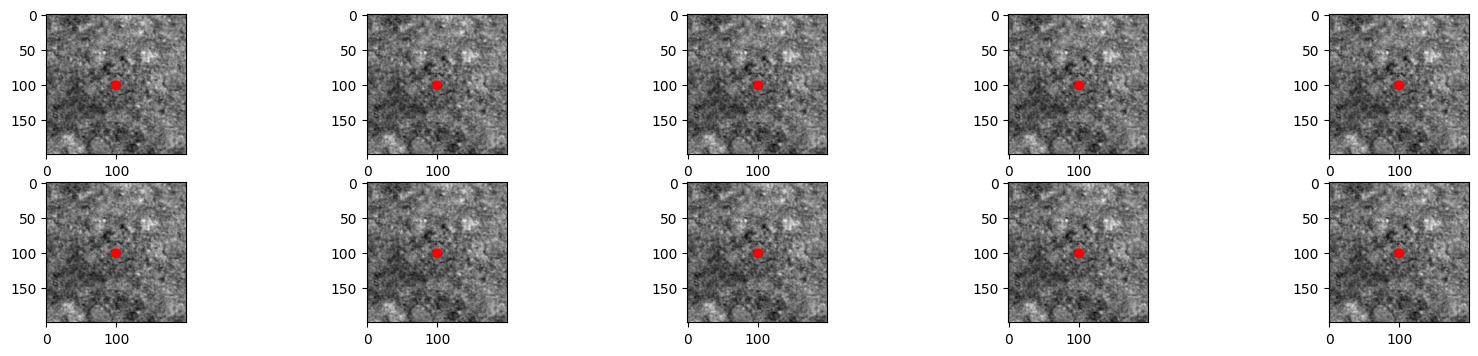

In [12]:
fig, ax = plt.subplots(2, 5, figsize=(20, 4))
for i, r in enumerate(results):
    center = np.array(r['updated_object_stack'].obj_center).astype(int)
    r_img = r['updated_object_stack'].data
    print(r_img.shape, center)
    rgn = r_img[r_img.shape[0] // 2, (center[1] - 100):center[1] + 100, center[2] - 100:center[2] + 100]
    ax[i // 5, i % 5].imshow(rgn, cmap='gray')
    ax[i // 5, i % 5].scatter(100, 100, c='r')
